In [267]:
# いつも使うやつ
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# pandasで全ての列を表示
pd.options.display.max_columns = None

# 図をipython notebook内で表示
%matplotlib inline

# DeplicatedWarningを避けるため
import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)

import sys
sys.path.append('./lib/')

# 交差検定をサクッとやるためのモジュールを読み込む
from sklearn.cross_validation import cross_val_score

# 説明変数つくるための関数
import feature_process_helper
import get_data
import learn

# submissionを書き込む関数
import write_submission

# plotを勉強する

In [2]:
# データをそれぞれ読み込む
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()

In [3]:
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.dummies(train, test, columns=['Pclass', 'Sex', 'Embarked'])
trian, test = feature_process_helper.family_size_int(train, test)
# train, test = feature_process_helper.drop(train, test, bye=['SibSp', 'Parch', 'Ticket', 'Cabin', 'Name_Title', 'Pclass_3', 'Sex_male', 'Embarked_Q'])

In [4]:
trian.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Name_Len,Name_Title,Age_Null_Flag,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q,FamilySize
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,23,Mr.,0,1,0,0,1,0,1,0,0,2
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,51,Mrs.,0,0,1,0,0,1,0,1,0,2
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,22,Miss.,0,1,0,0,0,1,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,44,Mrs.,0,0,1,0,0,1,1,0,0,2
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,24,Mr.,0,1,0,0,1,0,1,0,0,1


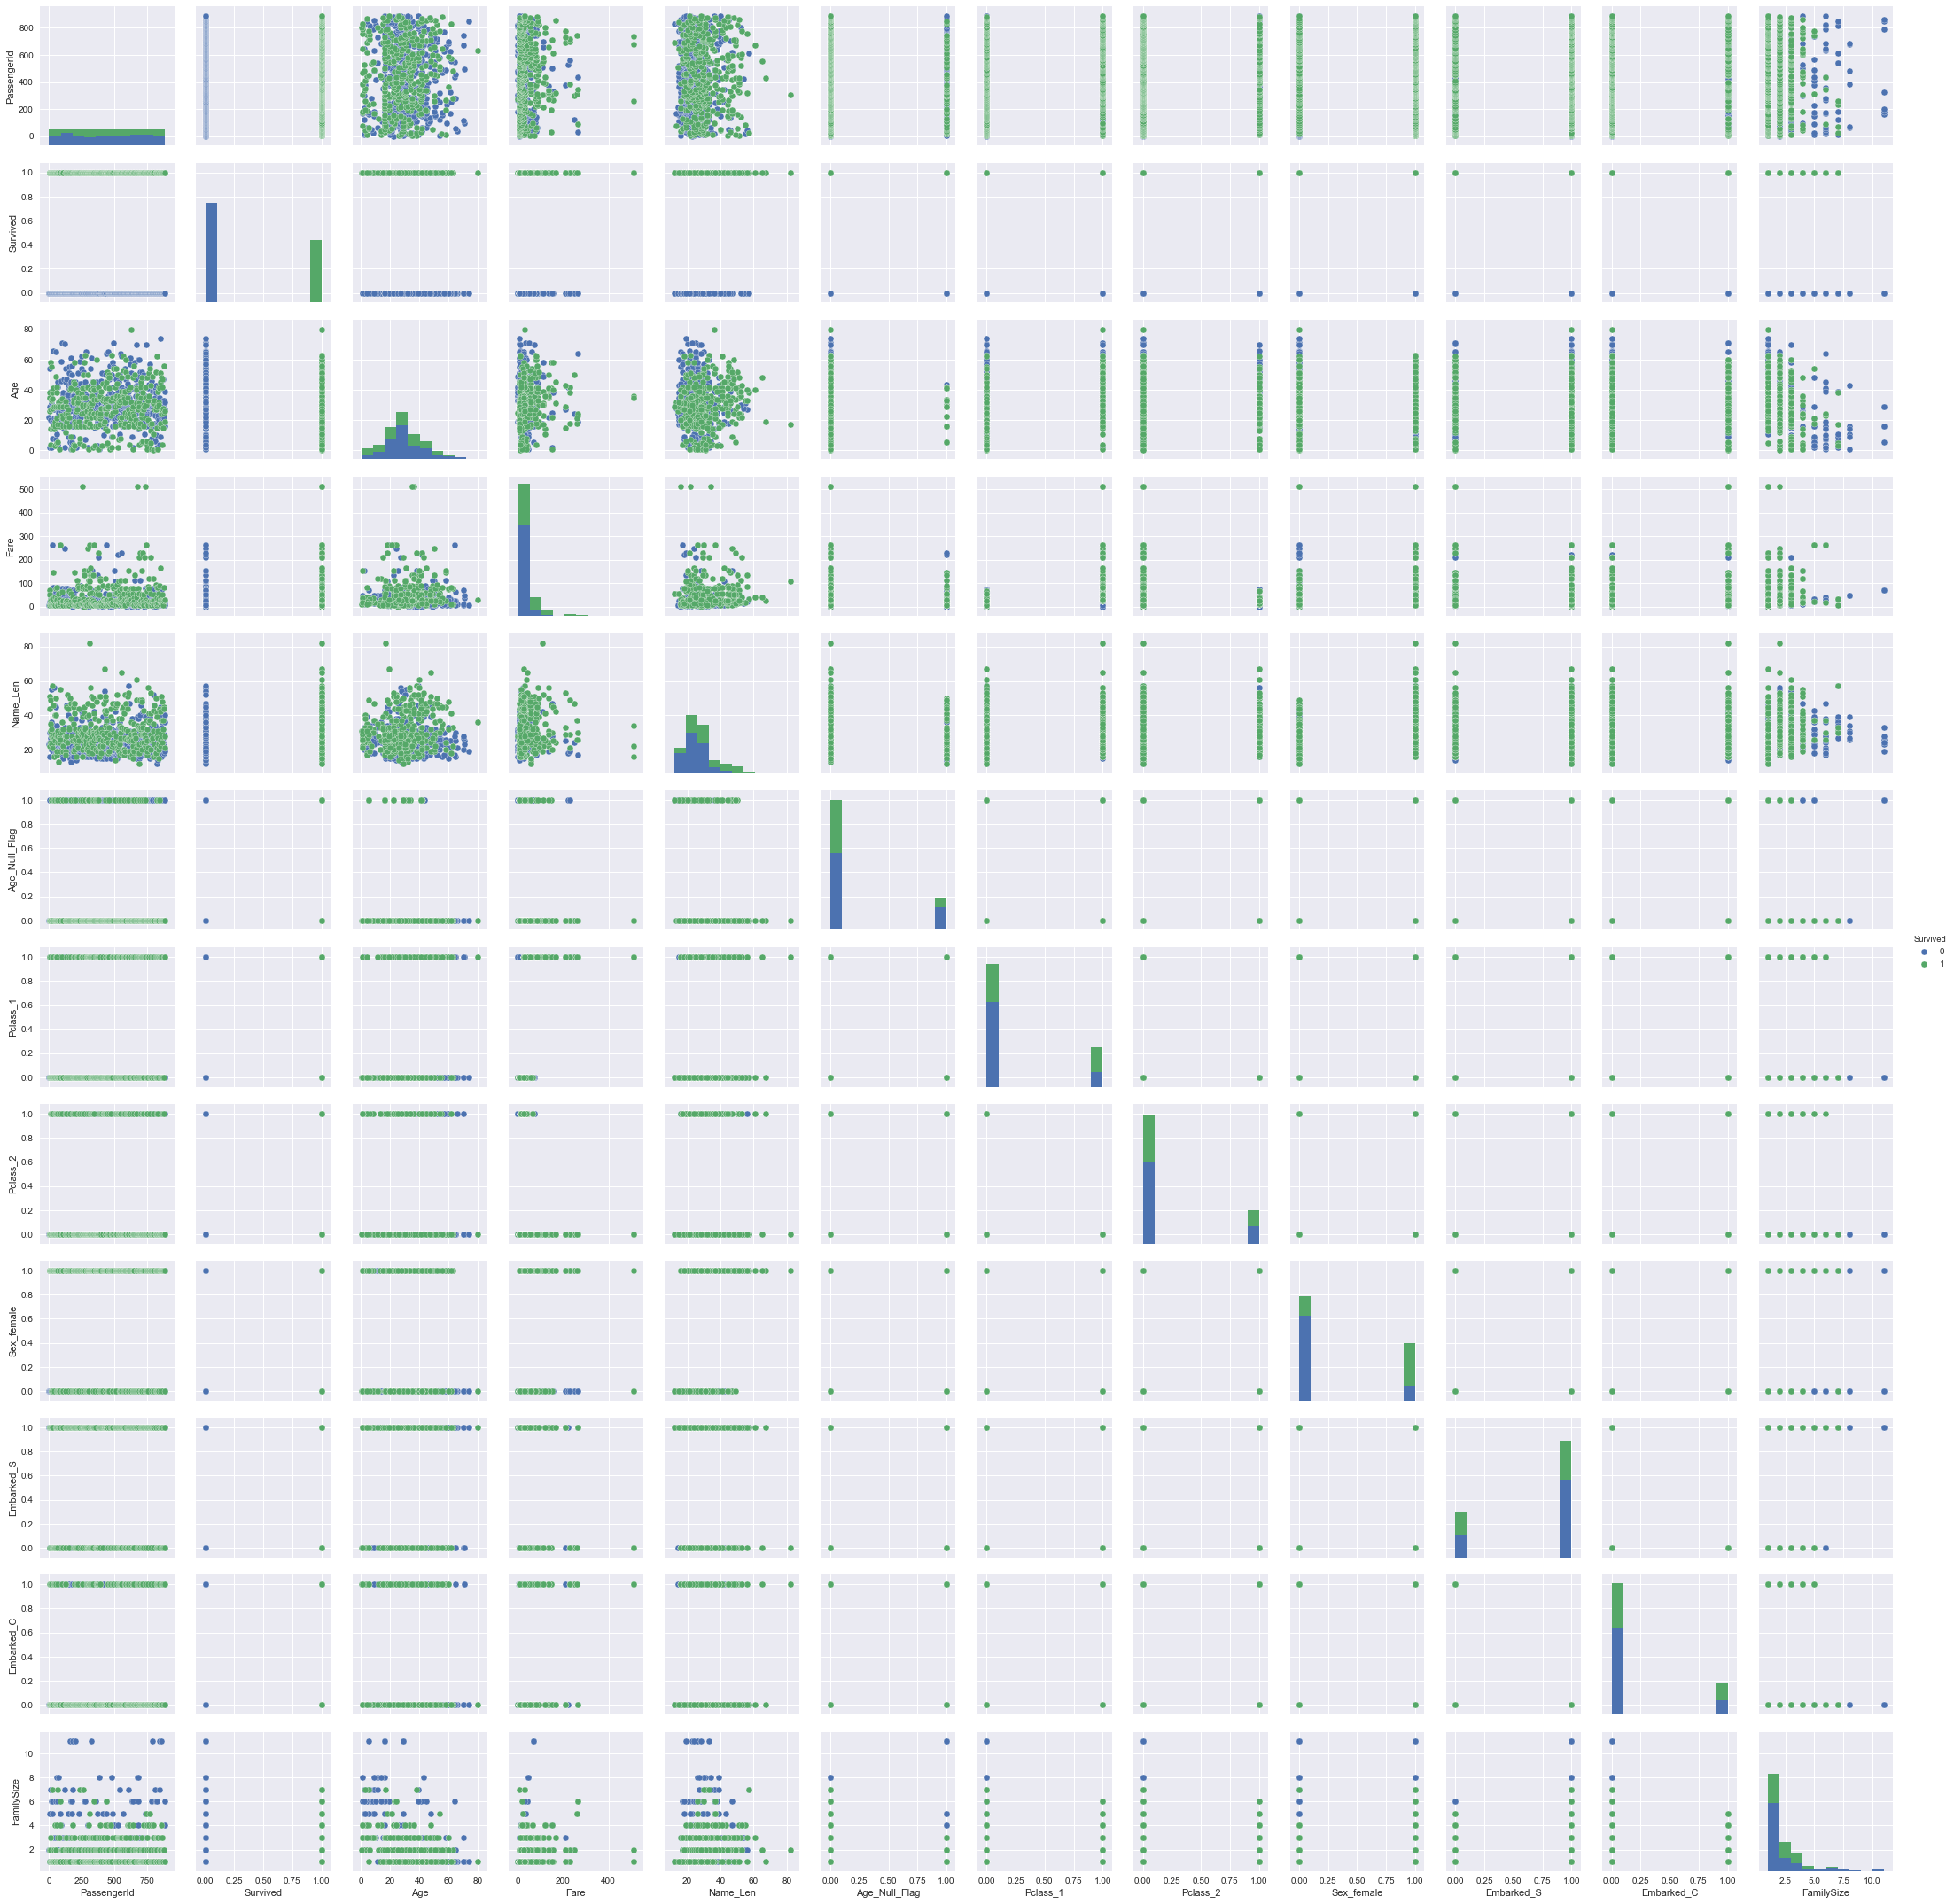

In [46]:
# 少ない数で相関みてみる
#sns.pairplot(train, hue='Survived')

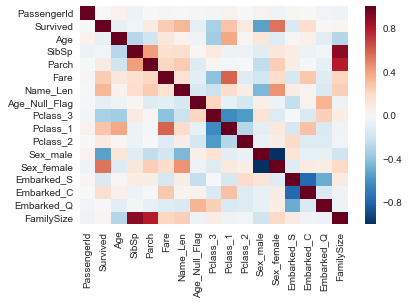

In [4]:
sns.heatmap(train.corr())

見た感じ。Fare, Name_Len, Pclass_3, Pclass_1, Sex_femaleの5つに相関ありそう

FareとName_Lenだけ、正則化する

In [5]:
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [6]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
train.loc[:, ['Fare', 'Name_Len']] = stdsc.fit_transform(train.loc[:, ['Fare', 'Name_Len']])
test.loc[:, ['Fare', 'Name_Len']] = stdsc.fit_transform(test.loc[:, ['Fare', 'Name_Len']])

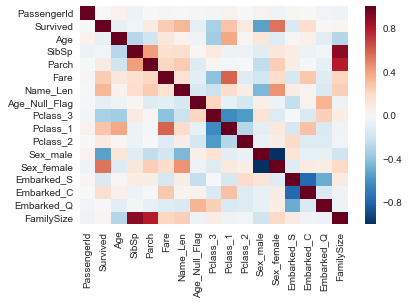

In [7]:
sns.heatmap(train.corr())

In [63]:
train.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Name_Len,Name_Title,Age_Null_Flag,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q,FamilySize
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,-0.502445,NaN,-0.427451,Mr.,0,1,0,0,1,0,1,0,0,2
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,0.786845,C85,2.590962,Mrs.,0,0,1,0,0,1,0,1,0,2
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,-0.488854,NaN,-0.535252,Miss.,0,1,0,0,0,1,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,0.420730,C123,1.836359,Mrs.,0,0,1,0,0,1,1,0,0,2
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,-0.486337,NaN,-0.319651,Mr.,0,1,0,0,1,0,1,0,0,1


In [8]:
x_train = train[['Fare', 'Name_Len', 'Pclass_3', 'Pclass_1', 'Sex_female']]
x_test = test[['Fare', 'Name_Len', 'Pclass_3', 'Pclass_1', 'Sex_female']]
y_train = train['Survived']

In [9]:
# 学習
search = learn.search(x_train, y_train)

In [10]:
search.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 50}

In [11]:
model = learn.learn(x_train, y_train, parameter=search.best_params_)

In [12]:
learn.validation(x_train, y_train, model)

CV accuracy: 0.804 +/- 0.024


検定力というのと外れ値検出 => 除外で相関を強くするという記事をみたので、試したい

In [13]:
write_submission._write(model=model, test=x_test, submission_df=submission_df)

0.73206

## AgeとSexだけ

In [14]:
# データをそれぞれ読み込む
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.dummies(train, test, columns=['Pclass', 'Sex', 'Embarked'])
trian, test = feature_process_helper.family_size_int(train, test)
# train, test = feature_process_helper.drop(train, test, bye=['SibSp', 'Parch', 'Ticket', 'Cabin', 'Name_Title', 'Pclass_3', 'Sex_male', 'Embarked_Q'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [17]:
x_train = train[['Age', 'Sex_female']]
x_test = test[['Age', 'Sex_female']]
y_train = train['Survived']

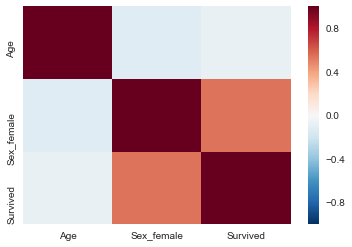

In [23]:
sns.heatmap(train[['Age', 'Sex_female', 'Survived']].corr())

In [24]:
search = learn.search(x_train, y_train)
model = learn.learn(x_train, y_train, parameter=search.best_params_)
learn.validation(x_train, y_train, model)
write_submission._write(model=model, test=x_test, submission_df=submission_df)

CV accuracy: 0.795 +/- 0.031


0.72727

## AgeとSexとPclass(1,2)

In [25]:
# データをそれぞれ読み込む
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.dummies(train, test, columns=['Pclass', 'Sex', 'Embarked'])
trian, test = feature_process_helper.family_size_int(train, test)
# train, test = feature_process_helper.drop(train, test, bye=['SibSp', 'Parch', 'Ticket', 'Cabin', 'Name_Title', 'Pclass_3', 'Sex_male', 'Embarked_Q'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [26]:
x_train = train[['Age', 'Sex_female', 'Pclass_1', 'Pclass_2']]
x_test = test[['Age', 'Sex_female', 'Pclass_1', 'Pclass_2']]
y_train = train['Survived']

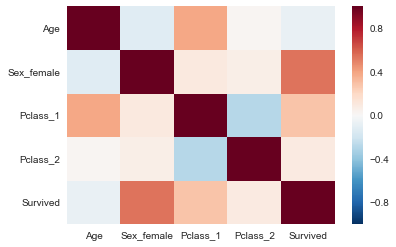

In [27]:
sns.heatmap(train[['Age', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Survived']].corr())

In [28]:
search = learn.search(x_train, y_train)
model = learn.learn(x_train, y_train, parameter=search.best_params_)
learn.validation(x_train, y_train, model)
write_submission._write(model=model, test=x_test, submission_df=submission_df)

CV accuracy: 0.803 +/- 0.042


0.72727

## AgeとSexとPclass(1,2)とFamilySize

In [29]:
# データをそれぞれ読み込む
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.dummies(train, test, columns=['Pclass', 'Sex', 'Embarked'])
trian, test = feature_process_helper.family_size_int(train, test)
# train, test = feature_process_helper.drop(train, test, bye=['SibSp', 'Parch', 'Ticket', 'Cabin', 'Name_Title', 'Pclass_3', 'Sex_male', 'Embarked_Q'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [31]:
x_train = train[['Age', 'Sex_female', 'Pclass_1', 'Pclass_2', 'FamilySize']]
x_test = test[['Age', 'Sex_female', 'Pclass_1', 'Pclass_2', 'FamilySize']]
y_train = train['Survived']

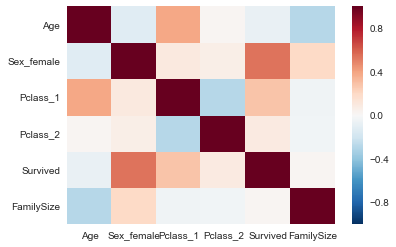

In [32]:
sns.heatmap(train[['Age', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Survived', 'FamilySize']].corr())

In [33]:
search = learn.search(x_train, y_train)
model = learn.learn(x_train, y_train, parameter=search.best_params_)
learn.validation(x_train, y_train, model)
write_submission._write(model=model, test=x_test, submission_df=submission_df)

CV accuracy: 0.826 +/- 0.039


0.71292
あがっと思いきや...

## AgeとSexとPclass(1,2)とFamilySizeとFare

In [34]:
# データをそれぞれ読み込む
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.dummies(train, test, columns=['Pclass', 'Sex', 'Embarked'])
trian, test = feature_process_helper.family_size_int(train, test)
# train, test = feature_process_helper.drop(train, test, bye=['SibSp', 'Parch', 'Ticket', 'Cabin', 'Name_Title', 'Pclass_3', 'Sex_male', 'Embarked_Q'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [36]:
x_train = train[['Age', 'Sex_female', 'Pclass_1', 'Pclass_2', 'FamilySize', 'Fare']]
x_test = test[['Age', 'Sex_female', 'Pclass_1', 'Pclass_2', 'FamilySize', 'Fare']]
y_train = train['Survived']

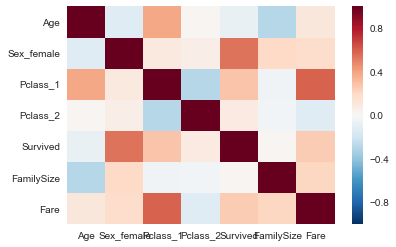

In [38]:
sns.heatmap(train[['Age', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Survived', 'FamilySize', 'Fare']].corr())

In [39]:
search = learn.search(x_train, y_train)
model = learn.learn(x_train, y_train, parameter=search.best_params_)
learn.validation(x_train, y_train, model)
write_submission._write(model=model, test=x_test, submission_df=submission_df)

CV accuracy: 0.838 +/- 0.045


0.76077

あがった！

In [42]:
pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(model.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
1,Sex_female,0.350028
5,Fare,0.239859
0,Age,0.214835
4,FamilySize,0.093825
2,Pclass_1,0.063892
3,Pclass_2,0.037560


## SexとFareのみ

In [43]:
# データをそれぞれ読み込む
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.dummies(train, test, columns=['Pclass', 'Sex', 'Embarked'])
trian, test = feature_process_helper.family_size_int(train, test)
# train, test = feature_process_helper.drop(train, test, bye=['SibSp', 'Parch', 'Ticket', 'Cabin', 'Name_Title', 'Pclass_3', 'Sex_male', 'Embarked_Q'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [44]:
x_train = train[['Sex_female', 'Fare']]
x_test = test[['Sex_female', 'Fare']]
y_train = train['Survived']

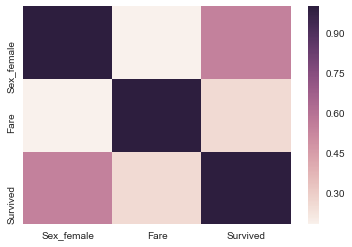

In [47]:
sns.heatmap(train[['Sex_female', 'Fare', 'Survived']].corr())

In [48]:
search = learn.search(x_train, y_train)
model = learn.learn(x_train, y_train, parameter=search.best_params_)
learn.validation(x_train, y_train, model)
write_submission._write(model=model, test=x_test, submission_df=submission_df)

CV accuracy: 0.790 +/- 0.043


0.73684

In [50]:
pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(model.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
1,Fare,0.595005
0,Sex_female,0.404995


効きは強くなったが、外したもので必要な変数がありそう

## SexとFareとAge

In [51]:
# データをそれぞれ読み込む
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.dummies(train, test, columns=['Pclass', 'Sex', 'Embarked'])
trian, test = feature_process_helper.family_size_int(train, test)
# train, test = feature_process_helper.drop(train, test, bye=['SibSp', 'Parch', 'Ticket', 'Cabin', 'Name_Title', 'Pclass_3', 'Sex_male', 'Embarked_Q'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [52]:
x_train = train[['Sex_female', 'Fare', 'Age']]
x_test = test[['Sex_female', 'Fare', 'Age']]
y_train = train['Survived']

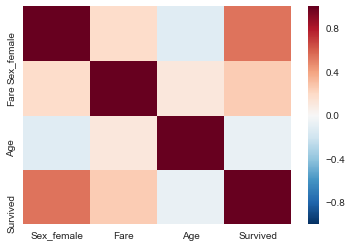

In [53]:
sns.heatmap(train[['Sex_female', 'Fare', 'Age', 'Survived']].corr())

In [54]:
search = learn.search(x_train, y_train)
model = learn.learn(x_train, y_train, parameter=search.best_params_)
learn.validation(x_train, y_train, model)
write_submission._write(model=model, test=x_test, submission_df=submission_df)

CV accuracy: 0.810 +/- 0.044


0.73206

In [56]:
pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(model.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
1,Fare,0.414916
2,Age,0.305370
0,Sex_female,0.279715


## SexとFareとFamilySize

In [57]:
# データをそれぞれ読み込む
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.dummies(train, test, columns=['Pclass', 'Sex', 'Embarked'])
trian, test = feature_process_helper.family_size_int(train, test)
# train, test = feature_process_helper.drop(train, test, bye=['SibSp', 'Parch', 'Ticket', 'Cabin', 'Name_Title', 'Pclass_3', 'Sex_male', 'Embarked_Q'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [58]:
x_train = train[['Sex_female', 'Fare', 'FamilySize']]
x_test = test[['Sex_female', 'Fare', 'FamilySize']]
y_train = train['Survived']

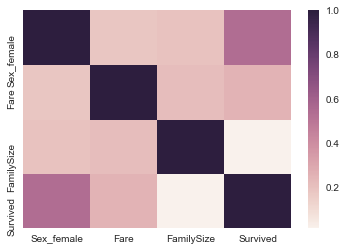

In [59]:
sns.heatmap(train[['Sex_female', 'Fare', 'FamilySize', 'Survived']].corr())

In [60]:
search = learn.search(x_train, y_train)
model = learn.learn(x_train, y_train, parameter=search.best_params_)
learn.validation(x_train, y_train, model)
write_submission._write(model=model, test=x_test, submission_df=submission_df)

CV accuracy: 0.806 +/- 0.027


0.76555

In [62]:
pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(model.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
0,Sex_female,0.511836
1,Fare,0.353446
2,FamilySize,0.134718


## SexとFareとFamilySizeとAge

In [63]:
# データをそれぞれ読み込む
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.dummies(train, test, columns=['Pclass', 'Sex', 'Embarked'])
trian, test = feature_process_helper.family_size_int(train, test)
# train, test = feature_process_helper.drop(train, test, bye=['SibSp', 'Parch', 'Ticket', 'Cabin', 'Name_Title', 'Pclass_3', 'Sex_male', 'Embarked_Q'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [64]:
x_train = train[['Sex_female', 'Fare', 'FamilySize', 'Age']]
x_test = test[['Sex_female', 'Fare', 'FamilySize', 'Age']]
y_train = train['Survived']

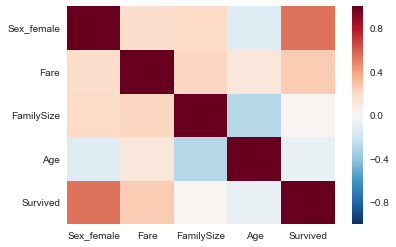

In [65]:
sns.heatmap(train[['Sex_female', 'Fare', 'FamilySize', 'Age', 'Survived']].corr())

In [66]:
search = learn.search(x_train, y_train)
model = learn.learn(x_train, y_train, parameter=search.best_params_)
learn.validation(x_train, y_train, model)
write_submission._write(model=model, test=x_test, submission_df=submission_df)

CV accuracy: 0.835 +/- 0.040


0.77512

In [67]:
pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(model.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
0,Sex_female,0.371903
1,Fare,0.302641
3,Age,0.214299
2,FamilySize,0.111157


## SexとFareとFamilySizeとPclass(2,3)

In [70]:
# データをそれぞれ読み込む
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.dummies(train, test, columns=['Pclass', 'Sex', 'Embarked'])
trian, test = feature_process_helper.family_size_int(train, test)
# train, test = feature_process_helper.drop(train, test, bye=['SibSp', 'Parch', 'Ticket', 'Cabin', 'Name_Title', 'Pclass_3', 'Sex_male', 'Embarked_Q'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [71]:
x_train = train[['Sex_female', 'Fare', 'FamilySize', 'Pclass_2', 'Pclass_3']]
x_test = test[['Sex_female', 'Fare', 'FamilySize', 'Pclass_2', 'Pclass_3']]
y_train = train['Survived']

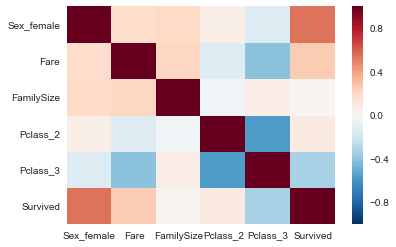

In [79]:
sns.heatmap(train[['Sex_female', 'Fare', 'FamilySize', 'Pclass_2', 'Pclass_3', 'Survived']].corr())

In [73]:
search = learn.search(x_train, y_train)
model = learn.learn(x_train, y_train, parameter=search.best_params_)
learn.validation(x_train, y_train, model)
write_submission._write(model=model, test=x_test, submission_df=submission_df)

CV accuracy: 0.810 +/- 0.034


0.77033

In [74]:
pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(model.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
1,Fare,0.526902
0,Sex_female,0.280770
2,FamilySize,0.108694
4,Pclass_3,0.064357
3,Pclass_2,0.019277


## SexとFareとFamilySizeとPclass(1,3)

In [75]:
# データをそれぞれ読み込む
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.dummies(train, test, columns=['Pclass', 'Sex', 'Embarked'])
trian, test = feature_process_helper.family_size_int(train, test)
# train, test = feature_process_helper.drop(train, test, bye=['SibSp', 'Parch', 'Ticket', 'Cabin', 'Name_Title', 'Pclass_3', 'Sex_male', 'Embarked_Q'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [76]:
x_train = train[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3']]
x_test = test[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3']]
y_train = train['Survived']

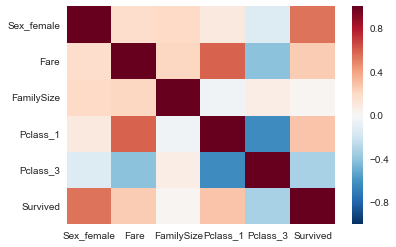

In [80]:
sns.heatmap(train[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'Survived']].corr())

In [78]:
search = learn.search(x_train, y_train)
model = learn.learn(x_train, y_train, parameter=search.best_params_)
learn.validation(x_train, y_train, model)
write_submission._write(model=model, test=x_test, submission_df=submission_df)

CV accuracy: 0.811 +/- 0.044


0.77512

In [81]:
pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(model.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
0,Sex_female,0.472658
1,Fare,0.287891
4,Pclass_3,0.102044
2,FamilySize,0.092940
3,Pclass_1,0.044468


## SexとFareとFamilySizeとPclass(1,2)

In [82]:
# データをそれぞれ読み込む
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.dummies(train, test, columns=['Pclass', 'Sex', 'Embarked'])
trian, test = feature_process_helper.family_size_int(train, test)
# train, test = feature_process_helper.drop(train, test, bye=['SibSp', 'Parch', 'Ticket', 'Cabin', 'Name_Title', 'Pclass_3', 'Sex_male', 'Embarked_Q'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [83]:
x_train = train[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_2']]
x_test = test[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_2']]
y_train = train['Survived']

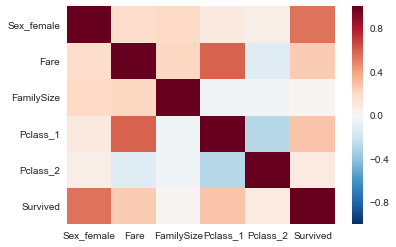

In [84]:
sns.heatmap(train[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_2', 'Survived']].corr())

In [85]:
search = learn.search(x_train, y_train)
model = learn.learn(x_train, y_train, parameter=search.best_params_)
learn.validation(x_train, y_train, model)
write_submission._write(model=model, test=x_test, submission_df=submission_df)

CV accuracy: 0.813 +/- 0.039


0.77033 

In [86]:
pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(model.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
1,Fare,0.454128
0,Sex_female,0.342555
2,FamilySize,0.116110
3,Pclass_1,0.050145
4,Pclass_2,0.037063


## Sex_female, Fare, FamilySize, Pclass(1, 3), Age

In [87]:
# データをそれぞれ読み込む
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.dummies(train, test, columns=['Pclass', 'Sex', 'Embarked'])
trian, test = feature_process_helper.family_size_int(train, test)
# train, test = feature_process_helper.drop(train, test, bye=['SibSp', 'Parch', 'Ticket', 'Cabin', 'Name_Title', 'Pclass_3', 'Sex_male', 'Embarked_Q'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [88]:
x_train = train[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'Age']]
x_test = test[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'Age']]
y_train = train['Survived']

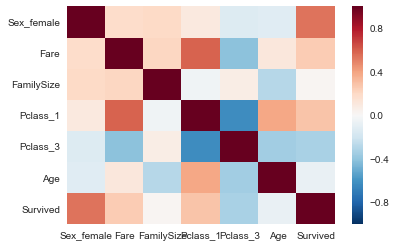

In [89]:
sns.heatmap(train[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'Age', 'Survived']].corr())

In [90]:
search = learn.search(x_train, y_train)
model = learn.learn(x_train, y_train, parameter=search.best_params_)
learn.validation(x_train, y_train, model)
write_submission._write(model=model, test=x_test, submission_df=submission_df)

CV accuracy: 0.834 +/- 0.050


0.75598

あれー？

In [91]:
pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(model.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
0,Sex_female,0.288431
1,Fare,0.261512
5,Age,0.259532
2,FamilySize,0.080465
4,Pclass_3,0.074745
3,Pclass_1,0.035315


## もう一度全体の相関を確認

In [92]:
# データをそれぞれ読み込む
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.dummies(train, test, columns=['Pclass', 'Sex', 'Embarked'])
trian, test = feature_process_helper.family_size_int(train, test)
# train, test = feature_process_helper.drop(train, test, bye=['SibSp', 'Parch', 'Ticket', 'Cabin', 'Name_Title', 'Pclass_3', 'Sex_male', 'Embarked_Q'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

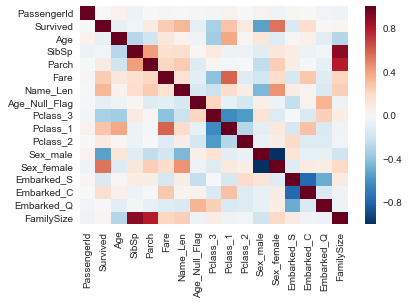

In [96]:
sns.heatmap(train.corr())

In [97]:
# 今のところ最高得点のやつの相関もみてみる
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()

train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.cabin_num(train, test)
train, test = feature_process_helper.cabin(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.fam_size(train, test)
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))
test['Ticket_Len'] = test['Ticket'].apply(lambda x: len(x))
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = feature_process_helper.drop(train, test, bye = ['Ticket'])

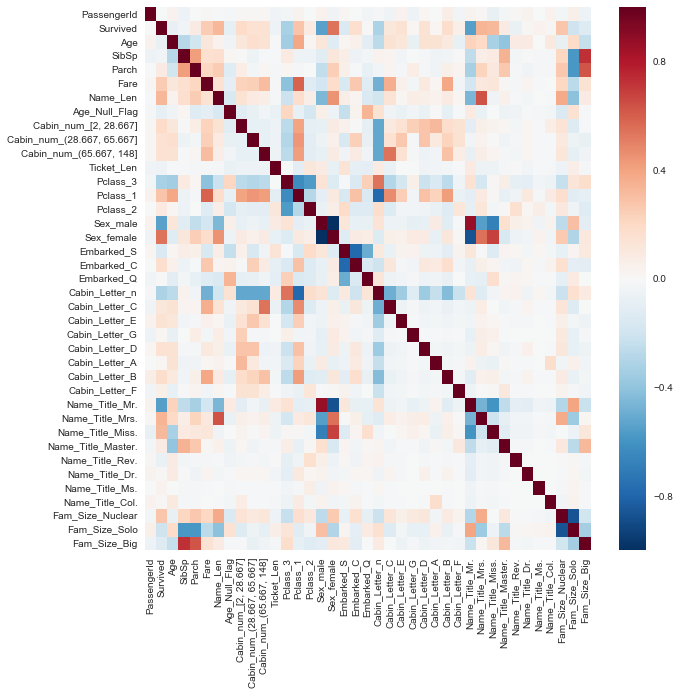

In [99]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(train.corr(), ax=ax)

んー、やっぱり同じカテゴリカルなデータでも、相関が高いやつは抜いちゃいけないのでは？と思った。

Sexの場合は２つなので、相関が同じだけど、3つ以上のカテゴリカルはそれぞれ値が違うのでその辺注意が必要と思った。


# Sex_female, Fare, FamilySize, Pclass(1, 3) + Name_Len

In [171]:
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()

train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.cabin_num(train, test)
train, test = feature_process_helper.cabin(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.fam_size(train, test)
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))
test['Ticket_Len'] = test['Ticket'].apply(lambda x: len(x))
trian, test = feature_process_helper.family_size_int(train, test)
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = feature_process_helper.drop(train, test, bye = ['Ticket'])

In [143]:
train.groupby(pd.cut(train['Name_Len'], 5))['Survived'].mean()

Name_Len
(11.93, 26]    0.270217
(26, 40]       0.452381
(40, 54]       0.810127
(54, 68]       0.700000
(68, 82]       1.000000
Name: Survived, dtype: float64

名前の長さに相関・・・・？

In [144]:
train.groupby(pd.cut(train['Name_Len'], 5))['Survived'].count()

Name_Len
(11.93, 26]    507
(26, 40]       294
(40, 54]        79
(54, 68]        10
(68, 82]         1
Name: Survived, dtype: int64

In [158]:
train.loc[train['Name_Len'] > 26, ['Name', 'Survived']]

,Name,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1
7,"Palsson, Master. Gosta Leonard",0
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1
9,"Nasser, Mrs. Nicholas (Adele Achem)",1
10,"Sandstrom, Miss. Marguerite Rut",1
12,"Saundercock, Mr. William Henry",0
13,"Andersson, Mr. Anders Johan",0
14,"Vestrom, Miss. Hulda Amanda Adolfina",0
15,"Hewlett, Mrs. (Mary D Kingcome)",1


In [162]:
train.loc[train['Name_Len'] <= 26, ['Name', 'Survived']]

,Name,Survived
0,"Braund, Mr. Owen Harris",0
2,"Heikkinen, Miss. Laina",1
4,"Allen, Mr. William Henry",0
5,"Moran, Mr. James",0
6,"McCarthy, Mr. Timothy J",0
11,"Bonnell, Miss. Elizabeth",1
16,"Rice, Master. Eugene",0
19,"Masselmani, Mrs. Fatima",1
20,"Fynney, Mr. Joseph J",0
21,"Beesley, Mr. Lawrence",1


In [161]:
train[['Survived', 'Name_Len']].corr()

,Survived,Name_Len
Survived,1.00000,0.33235
Name_Len,0.33235,1.00000


In [180]:
train['FamilySize'].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64

In [179]:
train.loc[train['Name_Len'] <= 26, ['Name', 'FamilySize']].groupby('FamilySize').count()

,Name
FamilySize,
1,377
2,60
3,37
4,9
5,6
6,12
8,1
11,5


In [205]:
train.groupby('FamilySize')['Survived'].mean()

FamilySize
1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64

In [202]:
train.loc[train['Name_Len'] <= 26, :].groupby('FamilySize')['Survived'].mean()

FamilySize
1     0.254642
2     0.300000
3     0.405405
4     0.666667
5     0.166667
6     0.083333
8     0.000000
11    0.000000
Name: Survived, dtype: float64

In [191]:
train.loc[train['Name_Len'] > 26, :].groupby('FamilySize')['Survived'].mean()

FamilySize
1     0.418750
2     0.702970
3     0.676923
4     0.750000
5     0.222222
6     0.200000
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64

In [197]:
train[['Survived', 'Name_Len', 'FamilySize']].corr()

,Survived,Name_Len,FamilySize
Survived,1.000000,0.33235,0.016639
Name_Len,0.332350,1.00000,0.238820
FamilySize,0.016639,0.23882,1.000000


In [243]:
train.groupby(pd.cut(train['Name_Len'], 3, 10), as_index=False)['FamilySize'].mean()

,FamilySize
0,1.774108
1,2.661538
2,2.000000


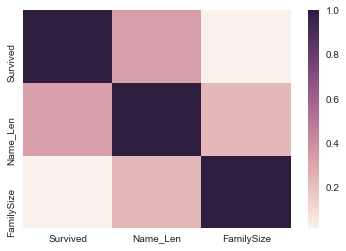

In [200]:
sns.heatmap(train[['Survived', 'Name_Len', 'FamilySize']].corr())

恐らく家族を数名連れいている人は助かった傾向にあったから？

女性の名前が27文字が多いから相関がでてるとか？

=> 名前が27文字以上の人は女性が多いのか

In [286]:
pd.pivot_table(train[(train['Name_Len'] <= 26)], index='Sex_female', columns='Survived', values='PassengerId', aggfunc='count')

Survived,0,1
Sex_female,,
0,341,58
1,29,79


In [287]:
pd.pivot_table(train[(train['Name_Len'] > 26)], index='Sex_female', columns='Survived', values='PassengerId', aggfunc='count')

Survived,0,1
Sex_female,,
0,127,51
1,52,154


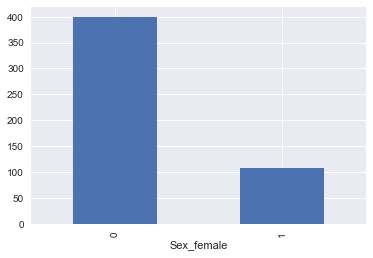

In [300]:
train[(train['Name_Len'] <= 26)].groupby('Sex_female')['PassengerId'].count().plot(kind='bar')

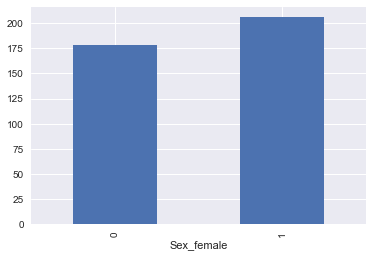

In [301]:
train[(train['Name_Len'] > 26)].groupby('Sex_female')['PassengerId'].count().plot(kind='bar')

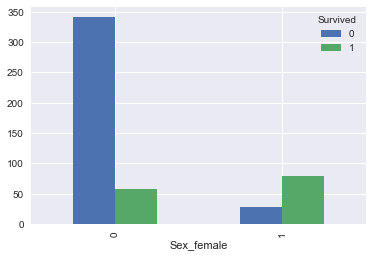

In [290]:
pd.pivot_table(train[(train['Name_Len'] <= 26)], index='Sex_female', columns='Survived', values='PassengerId', aggfunc='count').plot(kind='bar')

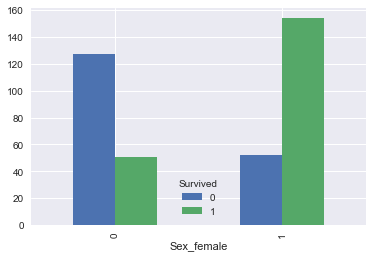

In [289]:
pd.pivot_table(train[(train['Name_Len'] > 26)], index='Sex_female', columns='Survived', values='PassengerId', aggfunc='count').plot(kind='bar')

女性が多いですね。生存率は女性が高いことはわかっているので、やはりそれの影響を受けてそうです。

というわけで、Name_Lenはいらないと思います。

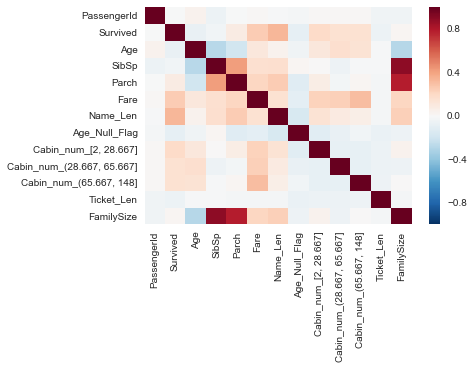

In [304]:
sns.heatmap(trian.corr())

# Sex_female, Fare, FamilySize, Pclass(1, 3) + AgeClass

age classなるものを作ってみる。

Ageには相関は低いが、子供と女性が優先されたと背景があるので、子供が助かっているはず。
ならば、AgeClassにしてカテゴリカルにしてみようと思います。

In [306]:
# データをそれぞれ読み込む
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.dummies(train, test, columns=['Pclass', 'Sex', 'Embarked'])
trian, test = feature_process_helper.family_size_int(train, test)
# train, test = feature_process_helper.drop(train, test, bye=['SibSp', 'Parch', 'Ticket', 'Cabin', 'Name_Title', 'Pclass_3', 'Sex_male', 'Embarked_Q'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [307]:
train.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Name_Len,Name_Title,Age_Null_Flag,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q,FamilySize
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,23,Mr.,0,1,0,0,1,0,1,0,0,2
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,51,Mrs.,0,0,1,0,0,1,0,1,0,2
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,22,Miss.,0,1,0,0,0,1,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,44,Mrs.,0,0,1,0,0,1,1,0,0,2
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,24,Mr.,0,1,0,0,1,0,1,0,0,1


In [406]:
# 0 ~ 15を子供、16 ~ ぐらいを大人とする
train['AgeClass'] = pd.Series()
train.loc[train['Age'] <= 7, 'AgeClass'] = 1
train.loc[(7 < train['Age']) & (train['Age'] <= 16), 'AgeClass'] = 2
train.loc[(16 < train['Age']), 'AgeClass'] = 3
train['AgeClass'] = train['AgeClass'].astype(int)

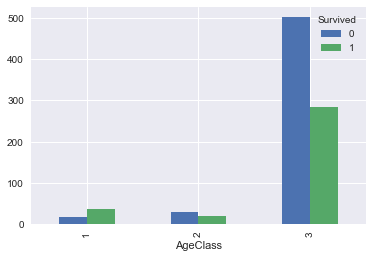

In [407]:
pd.pivot_table(train, index='AgeClass', columns='Survived', values='PassengerId', aggfunc='count', fill_value=0).plot(kind='bar')

In [409]:
# 0 ~ 7, 8 ~ 16, 17 ~ のクラス分け
train[['Survived', 'Age', 'AgeClass']].corr()

,Survived,Age,AgeClass
Survived,1.000000,-0.076577,-0.144474
Age,-0.076577,1.000000,0.586592
AgeClass,-0.144474,0.586592,1.000000


In [380]:
# 0 ~ 7, 8 ~ 16, 17 ~ 39, 40 ~ のクラス分け
train[['Survived', 'Age', 'AgeClass']].corr()

,Survived,Age,AgeClass
Survived,1.000000,-0.076577,-0.103314
Age,-0.076577,1.000000,0.855719
AgeClass,-0.103314,0.855719,1.000000


In [377]:
# 0 ~ 10, 11 ~ 40, 41 ~ のクラス分け
train[['Survived', 'Age', 'AgeClass']].corr()

,Survived,Age,AgeClass
Survived,1.000000,-0.076577,-0.065892
Age,-0.076577,1.000000,0.859248
AgeClass,-0.065892,0.859248,1.000000


In [374]:
# 0 ~ 6, 7 ~ 10, 11 ~ 20, 20 ~ 25, 26 ~ 30, 31 ~ 40, 41 ~のクラス分け
train[['Survived', 'Age', 'AgeClass']].corr()

,Survived,Age,AgeClass
Survived,1.000000,-0.076577,-0.077375
Age,-0.076577,1.000000,0.933967
AgeClass,-0.077375,0.933967,1.000000


In [371]:
# 0 ~ 6, 7 ~ 10, 11 ~ 20, 21 ~ 30, 31~ 40, 41 ~のクラス分け
train[['Survived', 'Age', 'AgeClass']].corr()

,Survived,Age,AgeClass
Survived,1.000000,-0.076577,-0.084976
Age,-0.076577,1.000000,0.859609
AgeClass,-0.084976,0.859609,1.000000


In [368]:
# 0 ~ 6, 7 ~ 10, 11 ~ 20, 21 ~ 40, 41 ~のクラス分け
train[['Survived', 'Age', 'AgeClass']].corr()

,Survived,Age,AgeClass
Survived,1.000000,-0.076577,-0.120086
Age,-0.076577,1.000000,0.877132
AgeClass,-0.120086,0.877132,1.000000


In [359]:
# 0 ~ 6, 7 ~ 16, 17 ~ 40, 41 ~のクラス分け
# train[['Survived', 'Age', 'AgeClass']].corr()

,Survived,Age,AgeClass
Survived,1.000000,-0.076577,-0.127532
Age,-0.076577,1.000000,0.804080
AgeClass,-0.127532,0.804080,1.000000


In [365]:
# 0 ~ 6, 7 ~ 40, 41 ~のクラス分け
train[['Survived', 'Age', 'AgeClass']].corr()

,Survived,Age,AgeClass
Survived,1.000000,-0.076577,-0.076391
Age,-0.076577,1.000000,0.841526
AgeClass,-0.076391,0.841526,1.000000


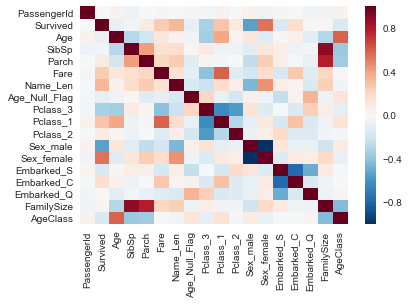

In [410]:
sns.heatmap(train.corr())

In [414]:
age_class_dummies = pd.get_dummies(trian['AgeClass'], prefix='AgeClass')

In [417]:
_train = pd.concat([train, age_class_dummies], axis=1)

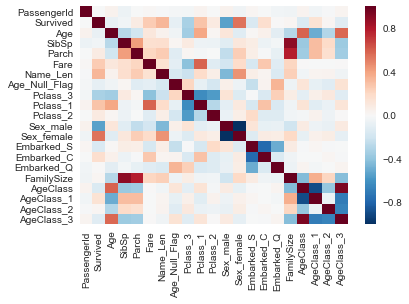

In [419]:
sns.heatmap(_train.corr())

AgeClass_1とAgeClass_3を使ったほうがよさそう

In [437]:
# データをそれぞれ読み込む
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.dummies(train, test, columns=['Pclass', 'Sex', 'Embarked'])
trian, test = feature_process_helper.family_size_int(train, test)
# train, test = feature_process_helper.drop(train, test, bye=['SibSp', 'Parch', 'Ticket', 'Cabin', 'Name_Title', 'Pclass_3', 'Sex_male', 'Embarked_Q'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [439]:
for _data in [train, test]:
    # 0 ~ 15を子供、16 ~ ぐらいを大人とする
    _data['AgeClass'] = pd.Series()
    _data.loc[_data['Age'] <= 7, 'AgeClass'] = 1
    _data.loc[(7 < _data['Age']) & (_data['Age'] <= 16), 'AgeClass'] = 2
    _data.loc[(16 < _data['Age']), 'AgeClass'] = 3
    _data['AgeClass'] = _data['AgeClass'].astype(int)

In [441]:
train_age_class_dummies = pd.get_dummies(trian['AgeClass'], prefix='AgeClass')
test_age_class_dummies = pd.get_dummies(test['AgeClass'], prefix='AgeClass')

train = pd.concat([train, train_age_class_dummies], axis=1)
test = pd.concat([test, test_age_class_dummies], axis=1)

In [442]:
del train['AgeClass_2']
del test['AgeClass_2']

In [445]:
x_train = train[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'AgeClass_1', 'AgeClass_3']]
x_test = test[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'AgeClass_1', 'AgeClass_3']]
y_train = train['Survived']

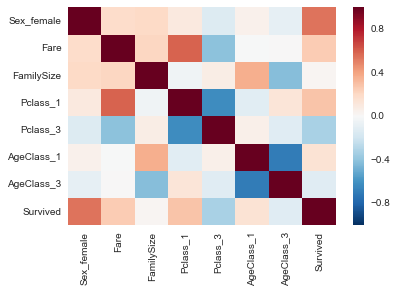

In [446]:
sns.heatmap(train[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'AgeClass_1', 'AgeClass_3', 'Survived']].corr())

In [447]:
x_test.head()

,Sex_female,Fare,FamilySize,Pclass_1,Pclass_3,AgeClass_1,AgeClass_3
0,0,7.8292,1,0,1,0,1
1,1,7.0000,2,0,1,0,1
2,0,9.6875,1,0,0,0,1
3,0,8.6625,1,0,1,0,1
4,1,12.2875,3,0,1,0,1


In [448]:
search = learn.search(x_train, y_train)
model = learn.learn(x_train, y_train, parameter=search.best_params_)
learn.validation(x_train, y_train, model)
write_submission._write(model=model, test=x_test, submission_df=submission_df)

CV accuracy: 0.829 +/- 0.040


0.76555

落ちた。。。。？

In [449]:
pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(model.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
0,Sex_female,0.384703
1,Fare,0.328277
2,FamilySize,0.091671
4,Pclass_3,0.089112
3,Pclass_1,0.042684
5,AgeClass_1,0.034546
6,AgeClass_3,0.029007


# Sex_female, Fare, FamilySize, Pclass(1, 3), Embarked(S, C)

In [450]:
# データをそれぞれ読み込む
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.dummies(train, test, columns=['Pclass', 'Sex', 'Embarked'])
trian, test = feature_process_helper.family_size_int(train, test)
# train, test = feature_process_helper.drop(train, test, bye=['SibSp', 'Parch', 'Ticket', 'Cabin', 'Name_Title', 'Pclass_3', 'Sex_male', 'Embarked_Q'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [451]:
x_train = train[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'Embarked_S', 'Embarked_C']]
x_test = test[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'Embarked_S', 'Embarked_C']]
y_train = train['Survived']

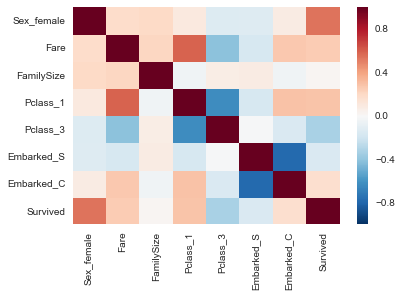

In [454]:
sns.heatmap(train[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'Embarked_S', 'Embarked_C', 'Survived']].corr())

In [455]:
search = learn.search(x_train, y_train)
model = learn.learn(x_train, y_train, parameter=search.best_params_)
learn.validation(x_train, y_train, model)
write_submission._write(model=model, test=x_test, submission_df=submission_df)

CV accuracy: 0.806 +/- 0.039


0.77033

In [456]:
pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(model.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
0,Sex_female,0.397221
1,Fare,0.329713
2,FamilySize,0.102994
4,Pclass_3,0.089929
3,Pclass_1,0.042685
5,Embarked_S,0.021498
6,Embarked_C,0.015960


# Sex_female, Fare, FamilySize, Pclass(1, 3), Embarked(S, C), Cabin_Letter_(n,C,E,D,A,B,F)

In [459]:
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()

train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.cabin_num(train, test)
train, test = feature_process_helper.cabin(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.fam_size(train, test)
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))
test['Ticket_Len'] = test['Ticket'].apply(lambda x: len(x))
trian, test = feature_process_helper.family_size_int(train, test)
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = feature_process_helper.drop(train, test, bye = ['Ticket'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

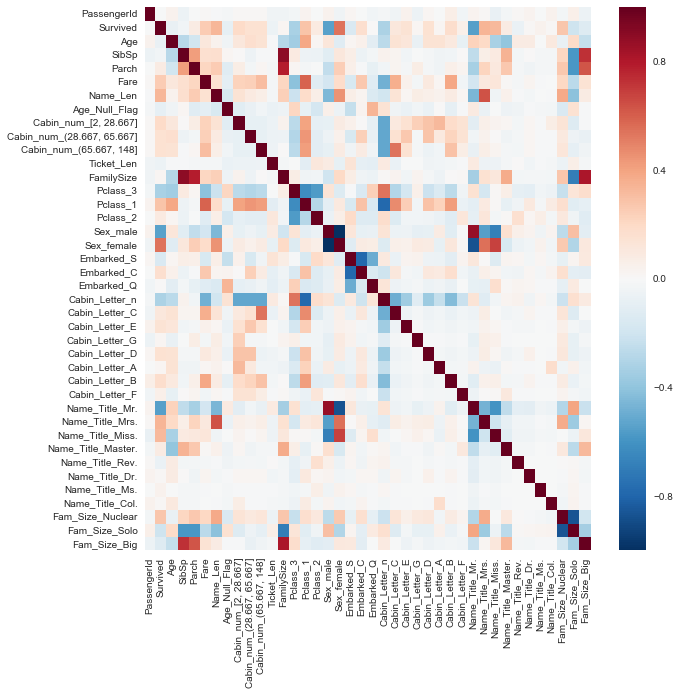

In [463]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(train.corr(), ax=ax)

In [467]:
train[['Cabin_Letter_n', 'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_G', 'Cabin_Letter_D', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F', 'Survived']].corr()

,Cabin_Letter_n,Cabin_Letter_C,Cabin_Letter_E,Cabin_Letter_G,Cabin_Letter_D,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_F,Survived
Cabin_Letter_n,1.000000,-0.488683,-0.354194,-0.123234,-0.359896,-0.240136,-0.433053,-0.223299,-0.316912
Cabin_Letter_C,-0.488683,1.000000,-0.051398,-0.017883,-0.052225,-0.034846,-0.062841,-0.032403,0.114652
Cabin_Letter_E,-0.354194,-0.051398,1.000000,-0.012961,-0.037852,-0.025256,-0.045547,-0.023486,0.145321
Cabin_Letter_G,-0.123234,-0.017883,-0.012961,1.000000,-0.013170,-0.008787,-0.015847,-0.008171,0.016040
Cabin_Letter_D,-0.359896,-0.052225,-0.037852,-0.013170,1.000000,-0.025663,-0.046280,-0.023864,0.150716
Cabin_Letter_A,-0.240136,-0.034846,-0.025256,-0.008787,-0.025663,1.000000,-0.030880,-0.015923,0.022287
Cabin_Letter_B,-0.433053,-0.062841,-0.045547,-0.015847,-0.046280,-0.030880,1.000000,-0.028715,0.175095
Cabin_Letter_F,-0.223299,-0.032403,-0.023486,-0.008171,-0.023864,-0.015923,-0.028715,1.000000,0.057935
Survived,-0.316912,0.114652,0.145321,0.016040,0.150716,0.022287,0.175095,0.057935,1.000000


Cabin_Letter_Gが低いのでそれを抜きます。

In [469]:
x_train = train[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'Embarked_S', 'Embarked_C', 'Cabin_Letter_n', 'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_D', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F']]
x_test = test[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'Embarked_S', 'Embarked_C', 'Cabin_Letter_n', 'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_D', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F']]
y_train = train['Survived']

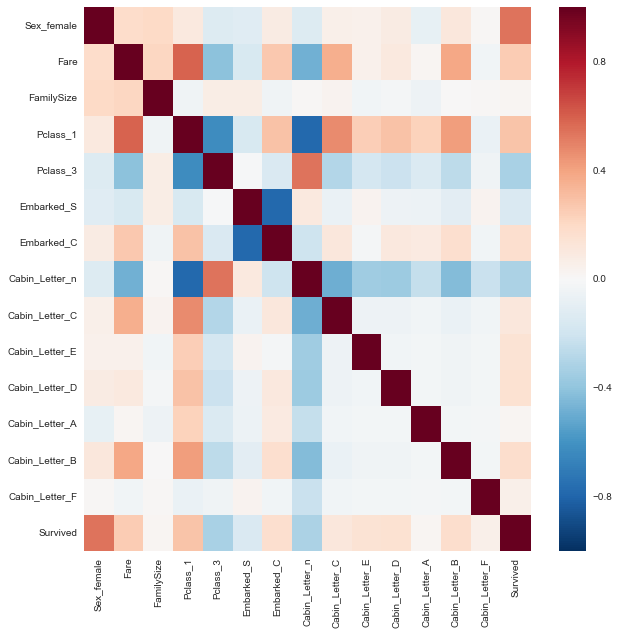

In [471]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(train[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'Embarked_S', 'Embarked_C', 'Cabin_Letter_n', 'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_D', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F', 'Survived']].corr(), ax=ax)

In [472]:
search = learn.search(x_train, y_train)
model = learn.learn(x_train, y_train, parameter=search.best_params_)
learn.validation(x_train, y_train, model)
write_submission._write(model=model, test=x_test, submission_df=submission_df)

CV accuracy: 0.812 +/- 0.037


0.77033

In [473]:
pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(model.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
0,Sex_female,0.392820
1,Fare,0.243446
2,FamilySize,0.094066
4,Pclass_3,0.079331
7,Cabin_Letter_n,0.058329
3,Pclass_1,0.039573
5,Embarked_S,0.025718
6,Embarked_C,0.018518
9,Cabin_Letter_E,0.013882
12,Cabin_Letter_B,0.011047


# Sex_female, Fare, FamilySize, Pclass(1, 3), Embarked(S, C), Cabin_Letter_(n,C,E,D,A,B,F), AgeClass(1,3)

In [479]:
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()

train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.cabin_num(train, test)
train, test = feature_process_helper.cabin(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.fam_size(train, test)
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))
test['Ticket_Len'] = test['Ticket'].apply(lambda x: len(x))
trian, test = feature_process_helper.family_size_int(train, test)
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = feature_process_helper.drop(train, test, bye = ['Ticket'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [481]:
for _data in [train, test]:
    # 0 ~ 15を子供、16 ~ ぐらいを大人とする
    _data['AgeClass'] = pd.Series()
    _data.loc[_data['Age'] <= 7, 'AgeClass'] = 1
    _data.loc[(7 < _data['Age']) & (_data['Age'] <= 16), 'AgeClass'] = 2
    _data.loc[(16 < _data['Age']), 'AgeClass'] = 3
    _data['AgeClass'] = _data['AgeClass'].astype(int)
    
train_age_class_dummies = pd.get_dummies(train['AgeClass'], prefix='AgeClass')
test_age_class_dummies = pd.get_dummies(test['AgeClass'], prefix='AgeClass')

train = pd.concat([train, train_age_class_dummies], axis=1)
test = pd.concat([test, test_age_class_dummies], axis=1)

del train['AgeClass_2']
del test['AgeClass_2']

In [482]:
x_train = train[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'Embarked_S', 'Embarked_C', 'Cabin_Letter_n', 'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_D', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F', 'AgeClass_1', 'AgeClass_3']]
x_test = test[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'Embarked_S', 'Embarked_C', 'Cabin_Letter_n', 'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_D', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F', 'AgeClass_1', 'AgeClass_3']]
y_train = train['Survived']

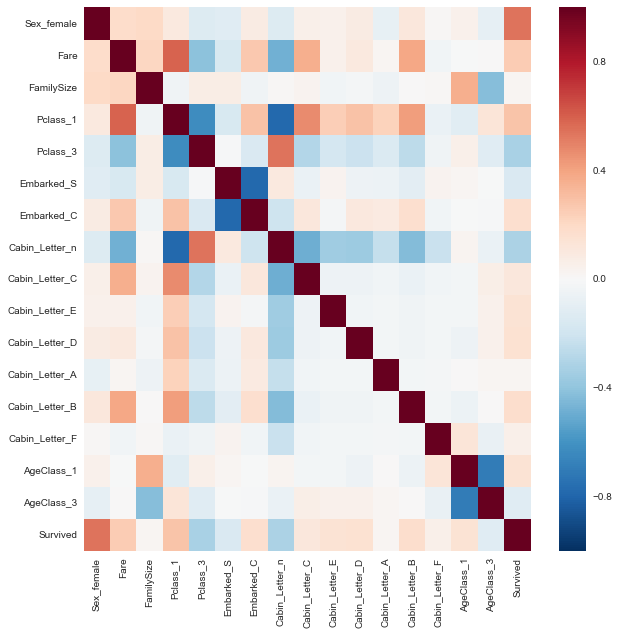

In [483]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(train[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'Embarked_S', 'Embarked_C', 'Cabin_Letter_n', 'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_D', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F', 'AgeClass_1', 'AgeClass_3',  'Survived']].corr(), ax=ax)

In [484]:
search = learn.search(x_train, y_train)
model = learn.learn(x_train, y_train, parameter=search.best_params_)
learn.validation(x_train, y_train, model)
write_submission._write(model=model, test=x_test, submission_df=submission_df)

CV accuracy: 0.827 +/- 0.050


0.77512

In [486]:
pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(model.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
0,Sex_female,0.449753
1,Fare,0.176034
4,Pclass_3,0.085394
2,FamilySize,0.083013
7,Cabin_Letter_n,0.058685
3,Pclass_1,0.045797
14,AgeClass_1,0.027194
15,AgeClass_3,0.025702
5,Embarked_S,0.016658
6,Embarked_C,0.011295


# Sex_female, Fare, FamilySize, Pclass(1, 3), Embarked(S, C), Cabin_Letter_(n,C,E,D,A,B,F), Age

In [487]:
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()

train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.cabin_num(train, test)
train, test = feature_process_helper.cabin(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.fam_size(train, test)
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))
test['Ticket_Len'] = test['Ticket'].apply(lambda x: len(x))
trian, test = feature_process_helper.family_size_int(train, test)
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = feature_process_helper.drop(train, test, bye = ['Ticket'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [488]:
x_train = train[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'Embarked_S', 'Embarked_C', 'Cabin_Letter_n', 'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_D', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F', 'Age']]
x_test = test[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'Embarked_S', 'Embarked_C', 'Cabin_Letter_n', 'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_D', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F', 'Age']]
y_train = train['Survived']

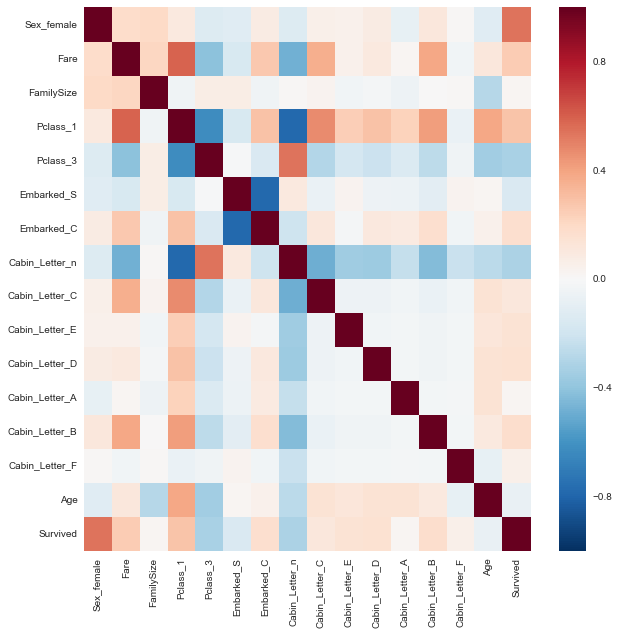

In [489]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(train[['Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'Embarked_S', 'Embarked_C', 'Cabin_Letter_n', 'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_D', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F', 'Age',  'Survived']].corr(), ax=ax)

In [490]:
search = learn.search(x_train, y_train)
model = learn.learn(x_train, y_train, parameter=search.best_params_)
learn.validation(x_train, y_train, model)
write_submission._write(model=model, test=x_test, submission_df=submission_df)

CV accuracy: 0.825 +/- 0.050


0.77512

In [491]:
pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(model.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
0,Sex_female,0.326365
1,Fare,0.191964
14,Age,0.184869
2,FamilySize,0.081592
4,Pclass_3,0.063129
7,Cabin_Letter_n,0.053257
3,Pclass_1,0.031298
5,Embarked_S,0.019351
6,Embarked_C,0.013817
9,Cabin_Letter_E,0.010040


# Sex_female, Fare, FamilySize, Pclass(1, 3), Embarked(S, C), Cabin_Letter_(n,C,E,D,A,B,F), TicketLen

In [492]:
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()

train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.cabin_num(train, test)
train, test = feature_process_helper.cabin(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.fam_size(train, test)
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))
test['Ticket_Len'] = test['Ticket'].apply(lambda x: len(x))
trian, test = feature_process_helper.family_size_int(train, test)
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = feature_process_helper.drop(train, test, bye = ['Ticket'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

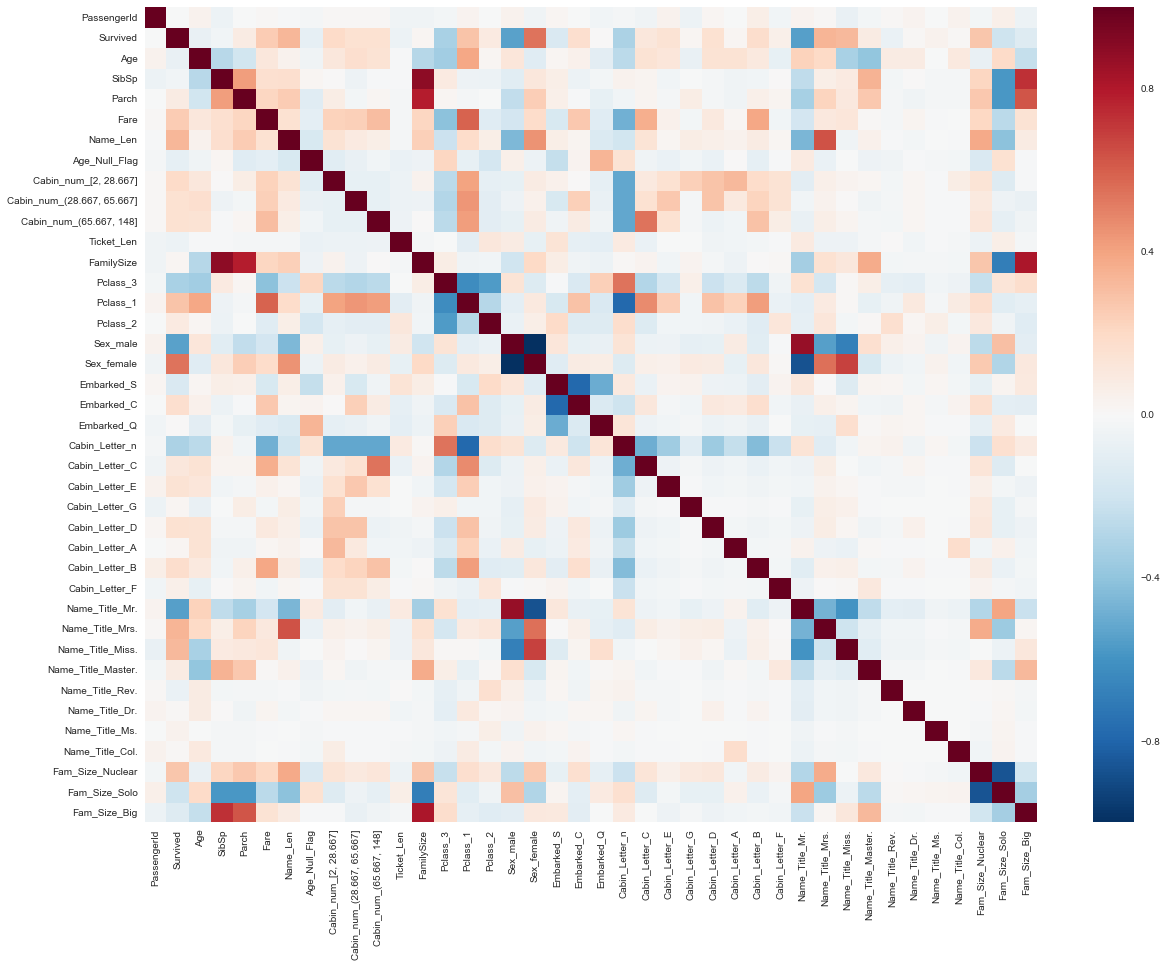

In [497]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(train.corr(), ax=ax)

In [500]:
x_train = train[['Ticket_Len', 'Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'Embarked_S', 'Embarked_C', 'Cabin_Letter_n', 'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_D', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F']]
x_test = test[['Ticket_Len', 'Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'Embarked_S', 'Embarked_C', 'Cabin_Letter_n', 'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_D', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F']]
y_train = train['Survived']

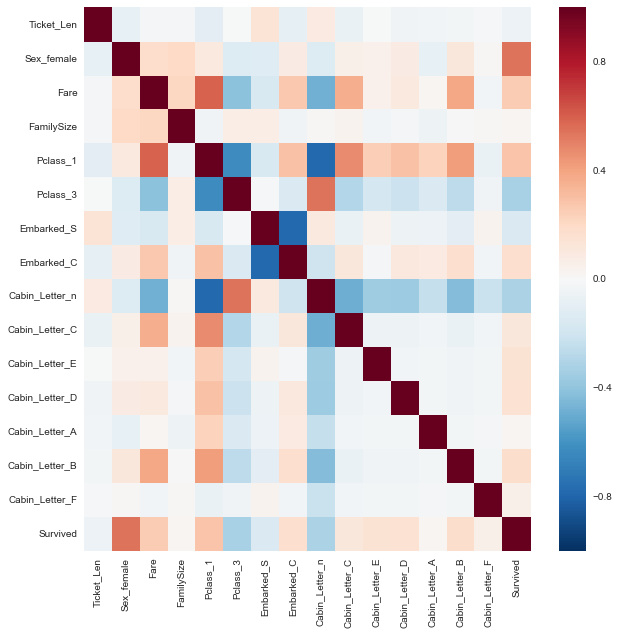

In [501]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(train[['Ticket_Len', 'Sex_female', 'Fare', 'FamilySize', 'Pclass_1', 'Pclass_3', 'Embarked_S', 'Embarked_C', 'Cabin_Letter_n', 'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_D', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F',  'Survived']].corr(), ax=ax)

In [502]:
search = learn.search(x_train, y_train)
model = learn.learn(x_train, y_train, parameter=search.best_params_)
learn.validation(x_train, y_train, model)
write_submission._write(model=model, test=x_test, submission_df=submission_df)

CV accuracy: 0.811 +/- 0.036


0.77033

In [504]:
pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(model.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
1,Sex_female,0.318989
2,Fare,0.254439
3,FamilySize,0.103660
0,Ticket_Len,0.102131
5,Pclass_3,0.066120
8,Cabin_Letter_n,0.042622
4,Pclass_1,0.022806
6,Embarked_S,0.022571
7,Embarked_C,0.016845
10,Cabin_Letter_E,0.014933
